In [1]:
include("./fdfd.jl");
using fdfd, PyPlot

# Radiating dipole example
This demonstrates a simple dipole radiating in free space. Although there is an assign_epsr!() call here, it sets $\epsilon_r = 1$ and therefore has no effect.

# Solver: pardiso failed, falling back to lufact()

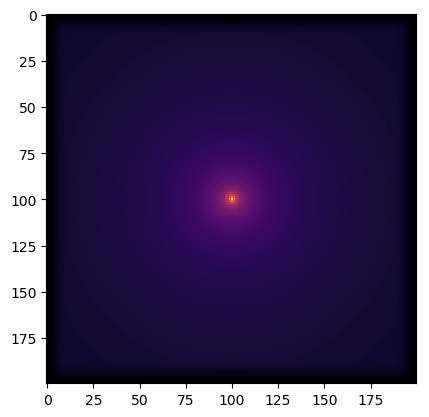

In [2]:
omega = 2*pi*200e12
N = (200,200);
Npml = (15,15)
xrange = (-2.5e-6,2.5e-6);
yrange = (-2.5e-6,2.5e-6);
geom = Geometry2D(N, Npml, xrange, yrange);

region_func(x,y) = -0.25e-6<=x<=0.25e-6 && -0.1e-6<=y<=0.1e-6;
assign_epsr!(geom, region_func, 1);
assign_src_point!(geom, (0, 0));

(Ez, Hx, Hy) = solve_driven_TM(geom, omega);
imshow(abs.(Ez), cmap="inferno");
show();

# Photonic waveguide transition
This demonstrates an indirect photonic mode transition in a waveguide. The even mode is launched from the left and is converted to the odd mode as it propagates.

# Solver: setup...
# Solver: 3.60E+05 unknowns
# Solver: starting matrix assembly
#         system matrices...
#         coupling matrices...
#         assembling...
# Solver: solving...
# Solver: pardiso failed, falling back to lufact()
# Solver: post processing...
 ──────────────────────────────────────────────────────────────────────────
                                   Time                   Allocations      
                           ──────────────────────   ───────────────────────
     Tot / % measured:          13.5s / 99.3%           2.94GiB / 100%     

 Section           ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────


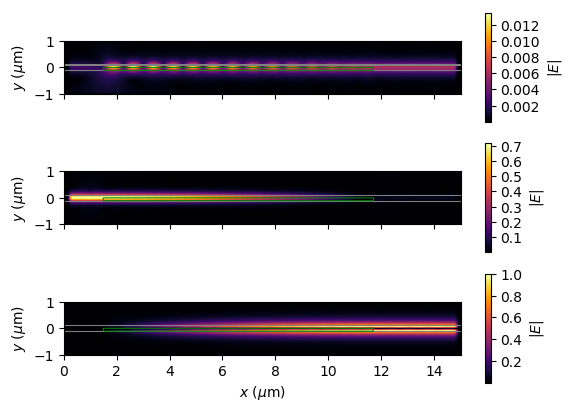

 solve                  1    11.1s  82.7%   11.1s   1.65GiB  56.2%  1.65GiB
 matrix assembly        1    1.78s  13.3%   1.78s   1.00GiB  34.0%  1.00GiB
   A_i                  3    774ms  5.77%   258ms    615MiB  20.5%   205MiB
   A                    1    361ms  2.69%   361ms    165MiB  5.48%   165MiB
   S_i                  3    354ms  2.64%   118ms    210MiB  6.98%  69.9MiB
   C_p                  1    263ms  1.96%   263ms   21.6MiB  0.72%  21.6MiB
   C_m                  1   27.4ms  0.20%  27.4ms   8.51MiB  0.28%  8.51MiB
 setup                  1    334ms  2.49%   334ms    126MiB  4.19%   126MiB
 post processing        1    202ms  1.50%   202ms    168MiB  5.61%   168MiB
 ──────────────────────────────────────────────────────────────────────────


In [3]:
omega0 = 2*pi*1.939e14;
Omega = 4.541e14;

Nsb = 1;
N = (600,200);
Npml = (15,10)
xrange = (0.0,15e-6);
yrange = (-1e-6,1e-6);
a = 0.2202e-6;
q = 2.9263e6;
Δϵ = 1;


geom = Geometry2D(N, Npml, xrange, yrange);
mod = Modulator(geom, Omega, Nsb);

region_wg(x,y) = -a/2<=y<=a/2;
region_modulation(x,y) = 1.5e-6<=x<=11.7e-6 && -a/2<=y<=0;
modulation_function(x,y) = Δϵ*exp.(1im*q*x);

assign_epsr!(mod.geom, region_wg, 12.25);
assign_mod_delta!(mod, region_modulation, modulation_function);
assign_src_mode!(mod.geom, "TM", omega0, omega0/c₀*3.5, [1e-6,0], "x", 61);

(Ez, Hx, Hy, omega) = solve_modulation_TM(mod, omega0);
plot_fields_abs(mod, Ez, cbar=true);